## Exercise 1
Consider the following dataset (Petricoin et al., Lancet, 2002).
Each column of A represents measurements taken from a patient. There are 216 columns representing 216
patients, out of which 121 have ovarian cancer. Each row represents the concentration of a different protein in the genomic signature of the patient.

You can download the dataset using the following commands in Colab:
```
!wget https://www.dropbox.com/s/bal044f83ezxiia/ovariancancer_obs.csv
!wget https://www.dropbox.com/s/r52sn5gmkd3y797/ovariancancer_grp.csv
```
Then you can create the matrix as follows:
```
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    ovariancancer_obs_path = './ovariancancer_obs.csv'
    ovariancancer_grp_path = './ovariancancer_grp.csv'
    A = np.genfromtxt(ovariancancer_obs_path, delimiter=',').transpose()
    f = open(ovariancancer_grp_path)
    grp = np.array(f.read().split("\n"))
    grp = grp[grp != '']
    n_features = A.shape[0]
    n_patients = A.shape[1]
    print('%d patients' % n_patients)
    print('%d features' % n_features)
```
1. Implement the randomized SVD.
2. Perform PCA on the data, by using the exact SVD algorithm. Then, plot the trend w.r.t. i of the
singular values σi . Now, repeat the computation by considering the randomized SVD algorithm of rank
k = 1, 5, 10, 50 and 100. Plot the approximate singular values together with the exact singular values.
Comment what you see.
3. Use PCA (with exact SVD) to perform dimensionality reduction on the dataset for rank k = 1, 5, 10, 50
and 100. Compute the reconstruction error of the dataset as a function of k. Repeat the same exercise by
using the randomized SVD algorithm. Repeat the same exercise by using the randomized SVD algorithm
with a +50% oversampling, that is by increasing by 50% the number of columns in the matrix random P
(round the quantity 1.5 k to the closest integer). Finally, plot the trend of the reconstruction error of the
dataset as a function of k in the three cases. Comment on the results.
4. Make a scatterplot of the first two principal components of the patients (obtained with exact SVD), by
plotting in red patients in the group ”cancer” and in blue the patients in the remaining group. Repeat
the same exercize with a rank k = 2 randomized SVD. Compute the execution time needed to run the
SVD algorithm in the two cases. Comment on the results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
ovariancancer_obs_path = './ovariancancer_obs.csv'
ovariancancer_grp_path = './ovariancancer_grp.csv'
A = np.genfromtxt(ovariancancer_obs_path, delimiter=',').transpose()
f = open(ovariancancer_grp_path)
grp = np.array(f.read().split("\n"))
grp = grp[grp != '']
n_features = A.shape[0]
n_patients = A.shape[1]
print('%d patients' % n_patients)
print('%d features' % n_features)

216 patients
4000 features


1. Implement the randomized SVD.

In [2]:
def randomized_SVD(A, k):
  n, m = A.shape[0], A.shape[1]
  P = np.random.randn(m, k)
  Z = A @ P
  Q, R = np.linalg.qr(Z)
  Y = Q.T @ A
  U_Y, s, VT = np.linalg.svd(Y, full_matrices = False)
  U = Q @ U_Y
  return U, s, VT

2. Perform PCA on the data, by using the exact SVD algorithm. Then, plot the trend w.r.t. i of the
singular values σi.

Now, repeat the computation by considering the randomized SVD algorithm of rank
k = 1, 5, 10, 50 and 100. Plot the approximate singular values together with the exact singular values.
Comment what you see.

(4000, 4000)(216,)(216, 216)


  0%|          | 0/5 [00:00<?, ?it/s]

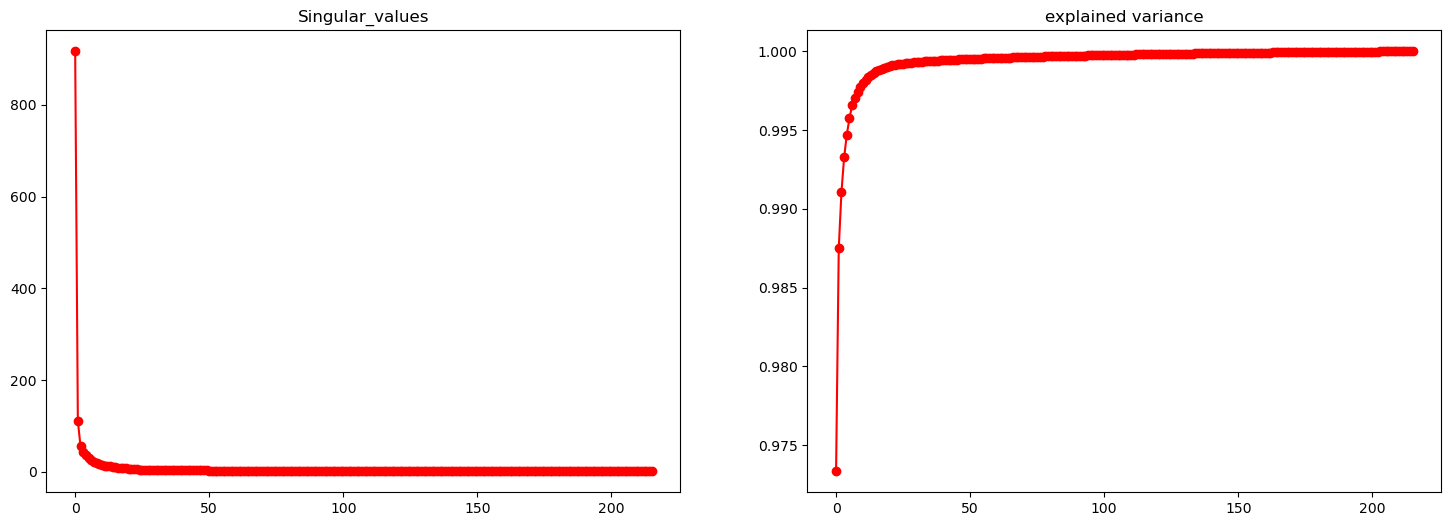

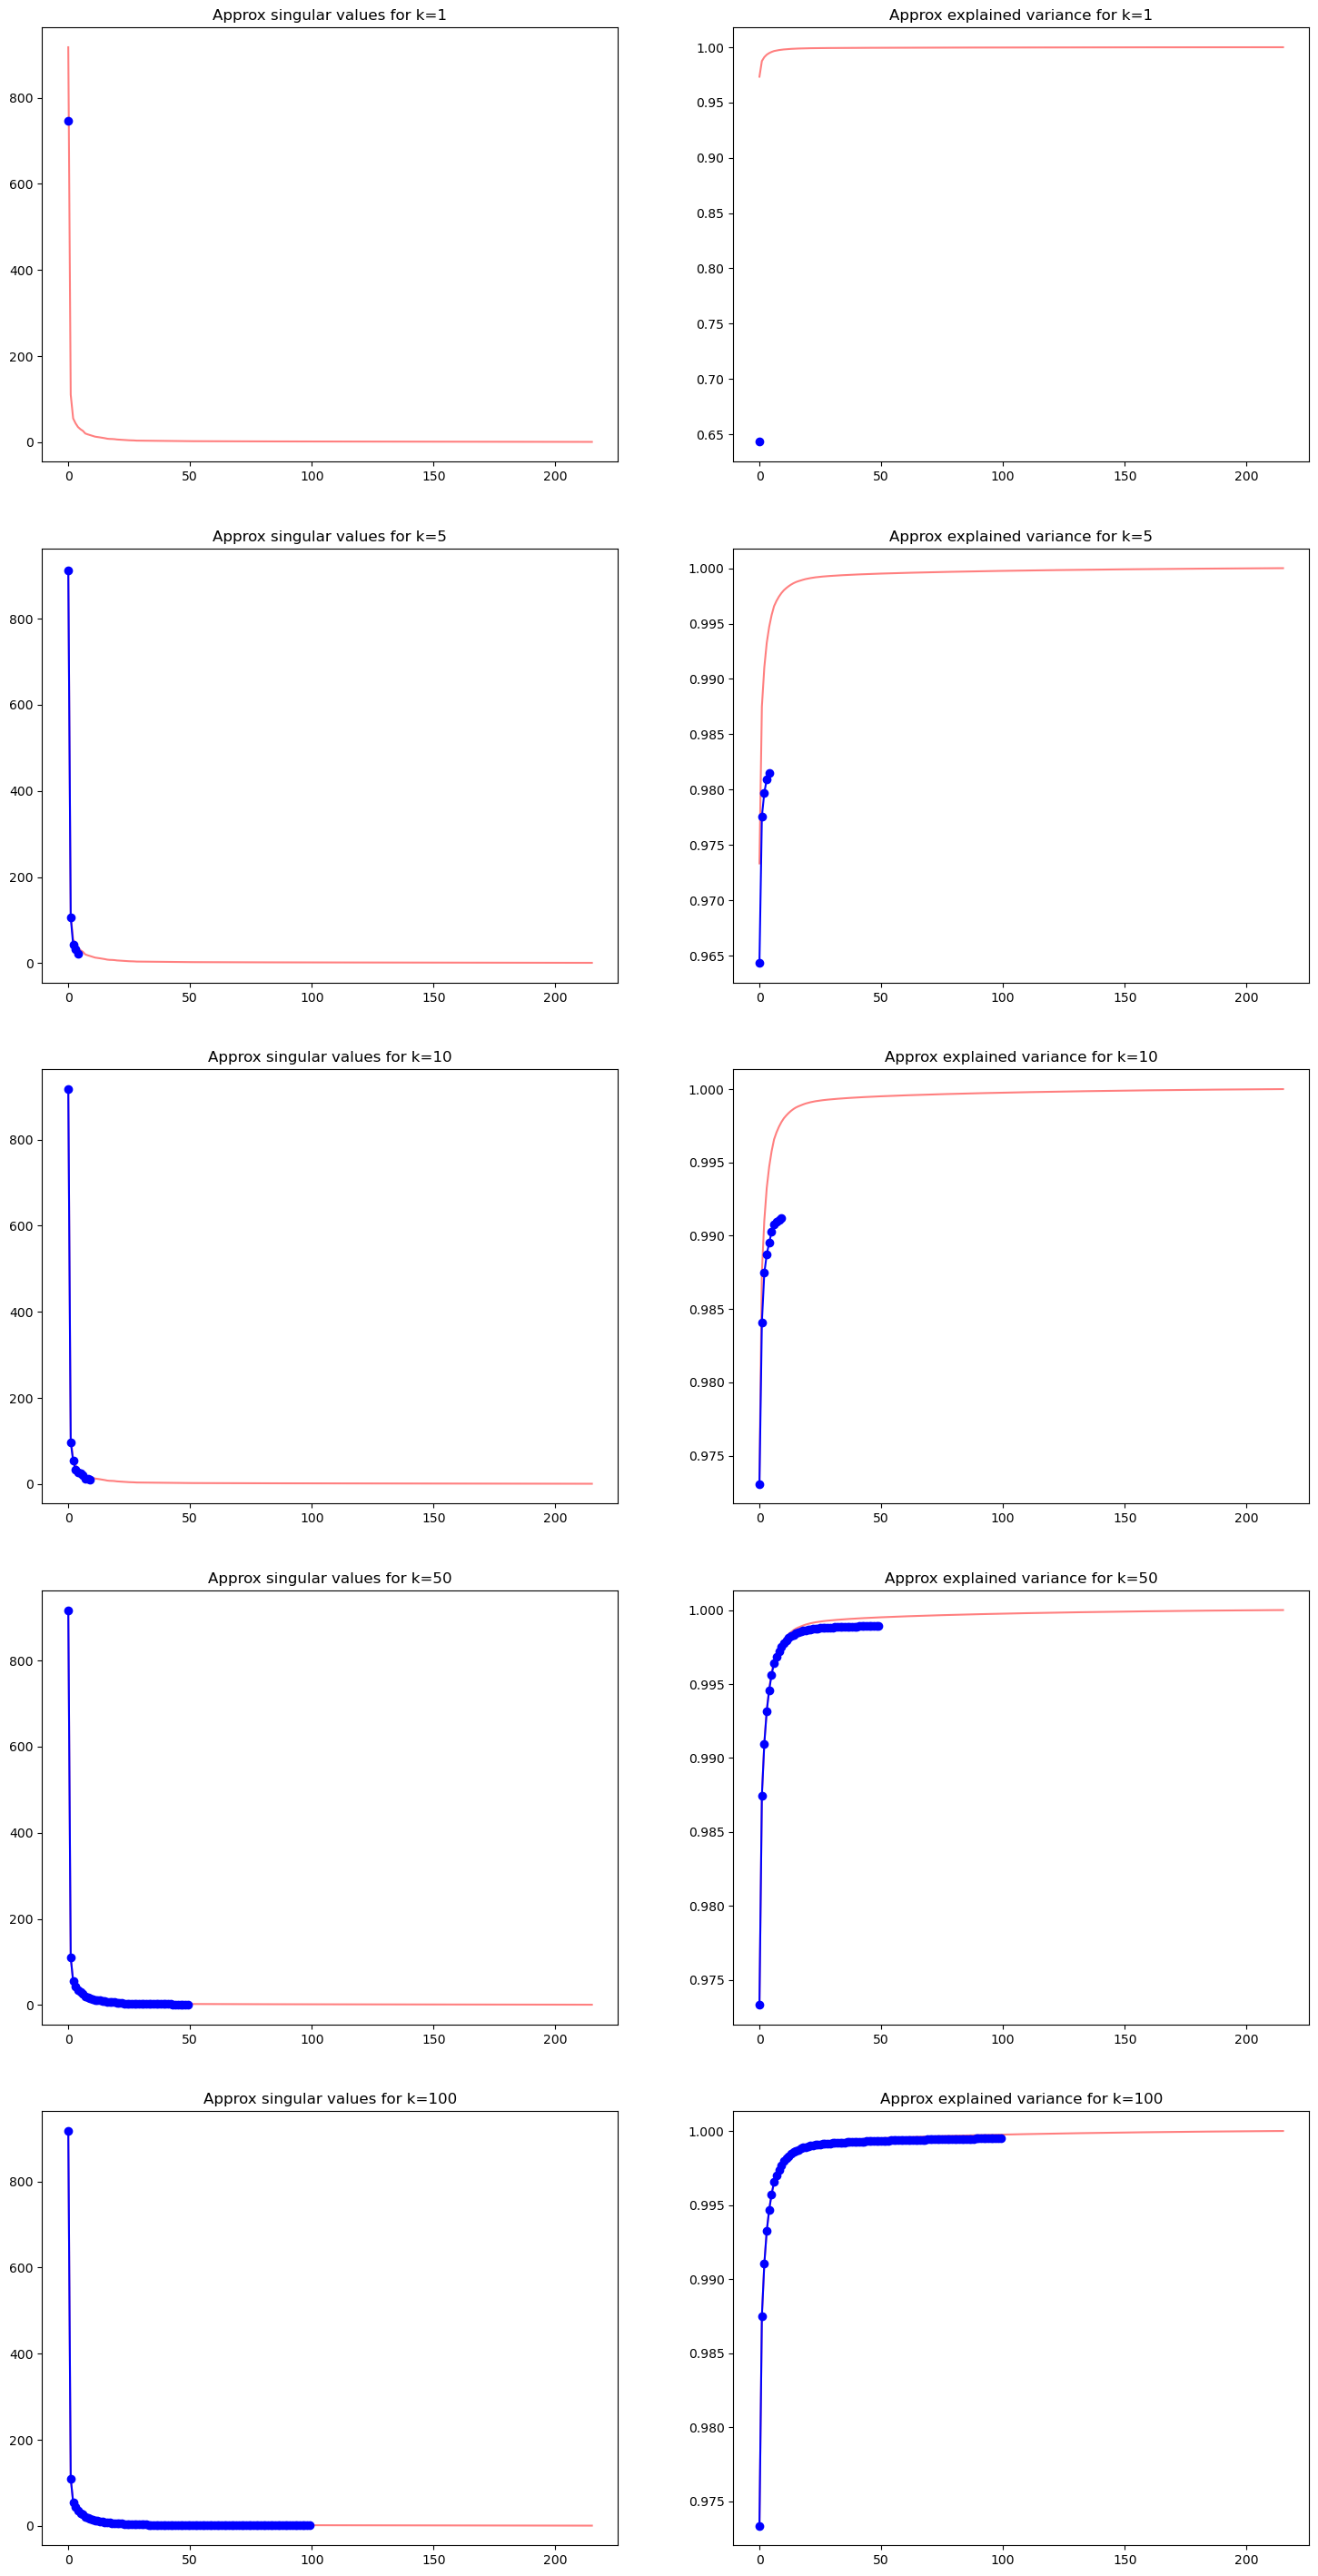

In [3]:
from tqdm.notebook import tqdm

# To perform PCA we need to normalize the data
A_mean = A.mean(axis=0)
A_std = A.std()
A_normalized = (A - A.mean())/A_std

# Perform PCA on the data, by using the exact SVD algorithm
U, s, VT = np.linalg.svd(A_normalized)
print(str(U.shape) + str(s.shape) + str(VT.shape))

# Then, plot the trend w.r.t. i of the singular values σi
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
axes[0].plot(s, 'o-', color = 'red')
axes[0].set_title('Singular_values')

axes[1].plot(np.cumsum(s**2)/np.sum(s**2), 'o-',  color = 'red')
axes[1].set_title('explained variance')

# Now, repeat the computation by considering the randomized SVD algorithm of rank k = 1, 5, 10, 50 and 100
# Plot the approximate singular values together with the exact singular values.
k = [1, 5, 10, 50, 100]
fig, axes = plt.subplots(nrows = len(k), ncols = 2, figsize = (18, 36))

for i in tqdm(range(len(k))):
    U_approx, s_approx, VT_approx = randomized_SVD(A_normalized, k[i])
    axes[i][0].plot(s, color='red', alpha=0.5)
    axes[i][0].plot(s_approx, 'o-', color='blue')
    axes[i][0].set_title(f'Approx singular values for k={k[i]}')

    axes[i][1].plot(np.cumsum(s**2)/np.sum(s**2), color='red', alpha=0.5)
    axes[i][1].plot(np.cumsum(s_approx**2)/np.sum(s**2), 'o-', color='blue')
    axes[i][1].set_title(f'Approx explained variance for k={k[i]}')

Comment what you see.

> The randomized SVD almost perfectly follows the trend described by the exact SVD.
> With a really small number of samples we already explain most of the variance of the matrix and for k >= 50 we have almost an exact representation of the dataset

3. Use PCA (with exact SVD) to perform dimensionality reduction on the dataset for rank k = 1, 5, 10, 50
and 100. Compute the reconstruction error of the dataset as a function of k. Repeat the same exercise by
using the randomized SVD algorithm. Repeat the same exercise by using the randomized SVD algorithm
with a +50% oversampling, that is by increasing by 50% the number of columns in the matrix random P
(round the quantity 1.5 k to the closest integer). Finally, plot the trend of the reconstruction error of the
dataset as a function of k in the three cases.

  0%|          | 0/5 [00:00<?, ?it/s]

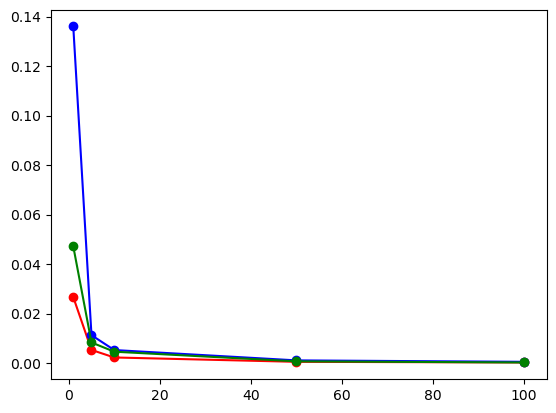

In [4]:
k = [1, 5, 10, 50, 100]
dim = A.shape[0]*A.shape[1]

def randomized_SVD_oversampling(A, k, oversampling=50):
  n, m = A.shape[0], A.shape[1]
  P = np.random.randn(m, int(k*(1 + oversampling/100)))
  Z = A @ P
  Q, R = np.linalg.qr(Z)
  Y = Q.T @ A
  U_Y, s, VT = np.linalg.svd(Y, full_matrices = False)
  U = Q @ U_Y
  return U, s, VT

exact_errors = list()
rand_errors = list()
over_errors = list()

for i in tqdm(range(len(k))):
    U_k, s_k, VT_k = randomized_SVD(A_normalized, k[i])
    U_o, s_o, VT_o = randomized_SVD_oversampling(A_normalized, k[i])
    
    r_exact = U[:,:min(len(U),k[i])] @ np.diag(s[:min(len(U),k[i])]) @ VT[:min(k[i],len(U)),:]
    r_rand = U_k @ np.diag(s_k) @ VT_k
    r_oversample = U_o @ np.diag(s_o) @ VT_o

    exact_errors.append((np.linalg.norm(A_normalized - r_exact, 'fro')**2)/dim)
    rand_errors.append((np.linalg.norm(A_normalized - r_rand, 'fro')**2)/dim)
    over_errors.append((np.linalg.norm(A_normalized - r_oversample, 'fro')**2)/dim)

plt.plot(k, exact_errors, 'o-', color='red')
plt.plot(k, rand_errors, 'o-', color='blue')
plt.plot(k, over_errors, 'o-', color='green')

plt.show()

Comment on the results.

> As expected the randomized SVD and the randomized SVD with oversampling performs sligtly worse than the exact SVD. However the difference in the MSE after the first ranks became very low so the reconstructions became almost indistinguishable from each other, proving that the randomized approch is a faster and reliable alternative to the classic exact SVD.
> We can also see how the oversampling helped the rSVD to reach lower error faster.

4. Make a scatterplot of the first two principal components of the patients (obtained with exact SVD), by
plotting in red patients in the group ”cancer” and in blue the patients in the remaining group. Repeat
the same exercize with a rank k = 2 randomized SVD. Compute the execution time needed to run the
SVD algorithm in the two cases. Comment on the results.

CPU times: user 5.83 s, sys: 366 ms, total: 6.2 s
Wall time: 6.27 s
CPU times: user 4.47 ms, sys: 0 ns, total: 4.47 ms
Wall time: 4.43 ms
(4000, 216)


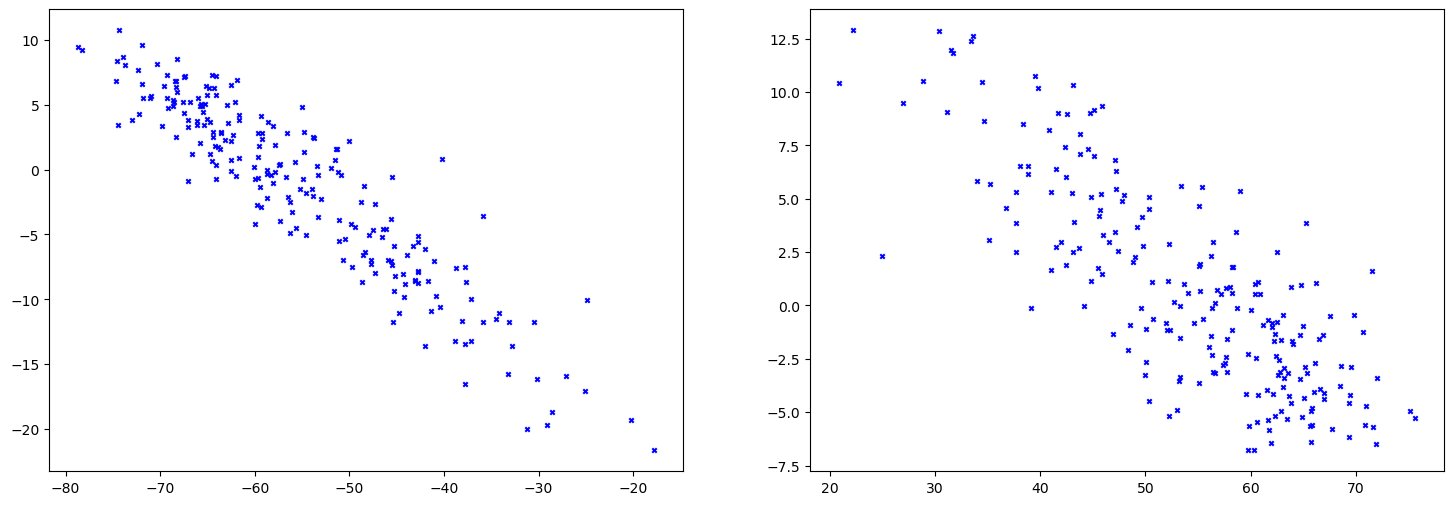

In [13]:
%time U, s, VT = np.linalg.svd(A)

%time Ur, sr, VTr = randomized_SVD(A, 2)

print(A.shape)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))


for i in range (A.shape[1]):
    x = A[:,i].T @ U[:,0]
    y = A[:,i].T @ U[:,1]
    xr = A[:,i].T @ Ur[:,0]
    yr = A[:,i].T @ Ur[:,1]
    if grp[i] == 'cancer':
        col = 'r'
    else:
        col = 'b'
    axes[0].scatter(x,y, marker='x', s=10,color=col)
    axes[1].scatter(xr,yr, marker='x', s=10,color=col)

plt.show()

Comment on the results.
> The general shape of the plot result somewhat similar so already for a low rank such as 2 we are able to get some information from the randomized SVD. Hovever the obtained results are very different because of the high approximation introduced. In particular this is highlighted by the ranges of the plot.
> In order to obtain a better result that is still order of magnitude faster we could have a bigger k
>
> Note that even though we have lost a lot of information the randomized SVD is 

## Exercise 2

Consider the subset of the Quantum Physics Dataset provided by Cornell University. The goal is to learn a
classification rule that differentiates between two types of particles generated in high energy collider experiments.
Load the data as follows:
```
X = np.genfromtxt('X.dat') # Features
y = np.genfromtxt('y.dat') # Labels (+1, -1)
```
Classify the data by solving the following minimization problem

   $$\ \ \ \min_w J(w) = \frac{1}{N}\sum_i{J(w)_i} $$

where

   $$\ \ \ J_i(w) = L(w^Tx_i,\ y_i) $$

with 

   $$\ \ \ L(s, y) = log(1 + \exp(-sy)) $$

1. Implement the Stochastic Gradient Descent algorithm (SGD) (batch size = 1) with constant learning rate
equal to 0.5. Perform 5000 iterations and initialize the weight vector to zero.
2. Repeat the minization using the SGD with the following update for the learning rate

    $$\ \ \ \eta_k = \frac{\eta_0}{1 + k/100} $$

    where k is the iteration number and η0 = 0.05. Comment the results.

In [6]:
import jax
import jax.numpy as jnp
import math

X = jnp.array(np.genfromtxt('X.dat')) # Features
y = jnp.array(np.genfromtxt('y.dat')) # Labels (+1, -1)

print(X.shape, y.shape)

(10000, 46) (10000,)


1. Implement the Stochastic Gradient Descent algorithm (SGD) (batch size = 1) with constant learning rate
equal to 0.5. Perform 5000 iterations and initialize the weight vector to zero.

  0%|          | 0/5000 [00:00<?, ?it/s]

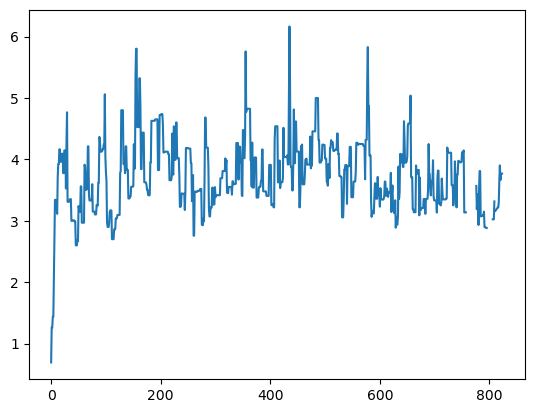

In [7]:
# Hyperparameters
num_epochs = 5000
eta = 5e-1
batch_size = 1

# Parameters
w_0 = jnp.zeros(X.shape[1])
n_samples = X.shape[0]

# Functions
def loss(X, y, w):
    s = w @ X.T
    sy = jnp.multiply(s, y)
    e = np.sum(jnp.log(1 + jnp.exp(-sy)))
    return e/X.shape[0]

grad_jit = jax.jit(jax.grad(loss, argnums = 2))

# Support
history_train = list()
history_train.append(loss(X, y, w_0))


# Stochastic Gradient Descent
def SGD(x_train, y_train, w_0, eta, num_epochs, batch_size, history_train):
    for i in tqdm(range(num_epochs)):
        idxs = np.random.choice(n_samples, batch_size)
        grads = grad_jit(x_train[idxs,:], y_train[idxs], w_0)   
        w_0 -= eta * grads
        history_train.append(loss(x_train, y_train, w_0))

SGD(X, y, w_0, eta, num_epochs, batch_size, history_train)
plt.plot(history_train)

2. Repeat the minization using the SGD with the following update for the learning rate

    $$\ \ \ \eta_k = \frac{\eta_0}{1 + k/100} $$

    where k is the iteration number and η0 = 0.05.

  0%|          | 0/5000 [00:00<?, ?it/s]

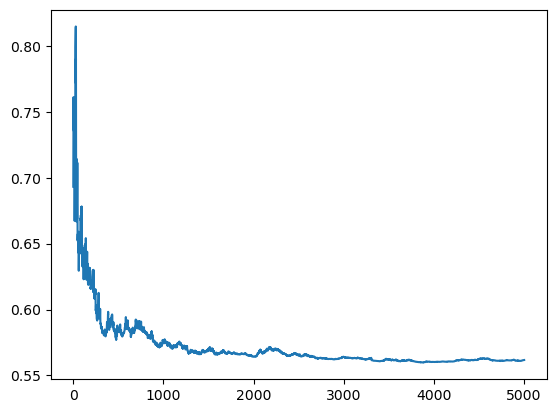

In [8]:
# Hyperparameters
num_epochs = 5000
eta_0 = 5e-2
batch_size = 1

# Parameters
w_0 = jnp.zeros(X.shape[1])
n_samples = X.shape[0]

# Support
history_train = list()
history_train.append(loss(X, y, w_0))

def SGD_decay(x_train, y_train, w_0, eta_0, num_epochs, batch_size, history_train):
    for i in tqdm(range(num_epochs)):
        idxs = np.random.choice(n_samples, batch_size)
        grads = grad_jit(x_train[idxs,:], y_train[idxs], w_0)  
        eta = eta_0/(1 + i/100)
        w_0 -= eta * grads
        history_train.append(loss(x_train, y_train, w_0))

SGD_decay(X, y, w_0, eta_0, num_epochs, batch_size, history_train)
plt.plot(history_train)

Comment the results.
> It is clear that the learning rate used in point 1 is too big so the SGD does not converge and instead diverges.
> The dynamic learning rate in the second point instead allows a fast convergence to a minimum that however migh be just a local one.Comment the results.
> It might also be possible that the learning rate decreases too much so the GD improvements are too small to be impactful even tought we haven't reached a minima yet.
> Setting a lower bound to the learning rate might be useful to avoid stopping to learn.
> Nonetheless an increase in the batch size and in the number of epoch may also povide better performances

## Exercise 3

Show that a multi-layer neural network with linear activation function s(x) = x is equivalent to a single layer
linear network. 

Assume that in each layer the inputs follow a Normal distribution with mean zero and small
variance, i.e. σ ≪ 1. For which of the activation functions s(x) = 1/(1 + exp(−x)), s(x) = tanh(x), s(x) =
relu(x) and s(x) = selu(x) is a deep network equivalent to a linear network for the given distribution ? The
selu function is given by:
<br><br>
$$
selu(x) = \begin{cases}
\text{$\lambda x$}, & \text{if $x > 0$}\\
\text{$\alpha (\exp(x)-1)$}, & \text{otherwise}
\end{cases}
$$

where λ ≈ 1.0507 and α ≈ 1.75814. (Hint: consider the case σ → 0 using a Taylor expansion around 0.)

>To show that a multi-layer neural network with a linear activation function \( s(x) = x \) we can follow these steps:
>1. The composition of linear functions is itself a linear function. So, if you have multiple layers of neurons, each applying a linear transformation to its inputs, and the activation function is linear, the overall transformation from the input layer to the output layer is still linear. (note that the identity is obviously a linear function)
>2. Since the overall transformation of a multi-layer network with linear activations is linear, then exists to a single-layer linear network that have the same output of this network. 

>Now, let's consider the other activation functions for the case where inputs follow a Normal distribution with mean zero and small variance $\sigma $ and determine if a deep network is equivalent to a linear network. When sigma is small than we can consider the input x around 0. If the output of the activation function can be approximated as a linear function in the poximity of 0 then the behaviour of the deep neural network may be approximated with a single neuronz.
>1. **Sigmoid \( s(x) = \frac{1}{1 + \exp(-x)} \):**
   The Taylor expansion of the sigmoid function around 0 is \( \frac{1}{2} + \frac{x}{4} - \frac{x^3}{48} + O(x^5) \). 
   For very small x, the higher-order terms become negligible, and the function behaves almost linearly around 0. 
>2. **Tanh \( s(x) = \tanh(x) \):**
   The Taylor expansion of the tanh function around 0 is \( x - \frac{x^3}{3} + O(x^5) \). Similar to the sigmoid, for very small x tanh behaves almost linearly around 0.
>3. **ReLU \( s(x) = \text{relu}(x) \):**
   The ReLU function is linear for \( x > 0 \) but zero for \( x \leq 0 \). Even for small x, ReLU does not behave linearly due to its piecewise nature.
>4. **SeLU:**
   For \( x > 0 \), SeLU is linear. For \( x \leq 0 \), it's \( \alpha(\exp(x) - 1) \). The Taylor expansion around 0 for the negative part includes higher-order terms, so for small x, SeLU does not behave as a linear function.

>In conclusion, for very small input x, sigmoid and tanh functions behave almost linearly, but they are not strictly equivalent to linear functions so a deep network with these activation functions is almost equivalent to a linear network. 
>ReLU and SeLU are not linear even for small x, therefore, a deep network with these activation functions is not equivalent to a linear network.